In [7]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt 

# 2 conv layers with 1 dense layer 
class CNN(nn.Module):
    ## in_channels = if grayscale image -> 1 if RGB -> 3
    ## num_classes = number of final classes we want to predict
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()

        # 1 convolution layer: 1 input channel, 8 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)

        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2 convolution layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # dense layer: if 28*28 pixels input image -> 2 max pool -> 16 (out channels) *  7*7 (2 max pool) 
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    ## x torch.tensor
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

input_size = 784  # 28x28 pixels (not directly used in CNN)
num_classes = 10  # digits 0-9
learning_rate = 0.001
batch_size = 64
num_epochs = 10  # Reduced for demonstration purposes




In [4]:
train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


In [5]:

def train_model(model,train_loader,test_loader,num_epochs,lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses,val_losses = [],[]
    train_accs, val_accs = [],[]

    for epoch in range(num_epochs):
        # traning
        model.train()
        running_loss,correct,total = 0.0,0,0

        # data and targets are batched 
        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):                    
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits,targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*data.size(0) 
            preds = logits.argmax(dim=1)

            correct += (preds == targets).sum().item()
            total += data.size(0)
        train_loss = running_loss/total
        train_acc = correct/total

        #testing
        model.eval()
        val_running_loss,val_correct,val_total = 0.0,0,0
        with torch.no_grad():
            for batch_index, (data, targets) in enumerate(tqdm(train_loader)):                    
                logits = model(data)
                loss = criterion(logits,targets)
                val_running_loss += loss.item() * data.size(0) # = 256 its the batch size
                preds = logits.argmax(dim=1)
                
                val_correct += (preds == targets).sum().item()
                val_total += data.size(0) 

        val_loss = val_running_loss/val_total
        val_acc = val_correct/val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}")
    return train_losses,val_losses,train_accs,val_accs


In [6]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)
train_losses,val_losses,train_accs,val_accs = train_model(model,train_loader,test_loader,10)

100%|██████████| 938/938 [00:09<00:00, 103.12it/s]


Epoch 1/10 - train_loss: 0.3347, val_loss: 0.1131, train_acc: 0.9032, val_acc: 0.9670


100%|██████████| 938/938 [00:09<00:00, 103.96it/s]


Epoch 2/10 - train_loss: 0.0952, val_loss: 0.0726, train_acc: 0.9713, val_acc: 0.9783


100%|██████████| 938/938 [00:09<00:00, 101.50it/s]


Epoch 3/10 - train_loss: 0.0707, val_loss: 0.0580, train_acc: 0.9789, val_acc: 0.9823


100%|██████████| 938/938 [00:09<00:00, 101.66it/s]


Epoch 4/10 - train_loss: 0.0586, val_loss: 0.0487, train_acc: 0.9823, val_acc: 0.9852


100%|██████████| 938/938 [00:09<00:00, 102.87it/s]


Epoch 5/10 - train_loss: 0.0503, val_loss: 0.0416, train_acc: 0.9842, val_acc: 0.9872


100%|██████████| 938/938 [00:09<00:00, 103.44it/s]


Epoch 6/10 - train_loss: 0.0450, val_loss: 0.0359, train_acc: 0.9860, val_acc: 0.9890


100%|██████████| 938/938 [00:09<00:00, 102.62it/s]


Epoch 7/10 - train_loss: 0.0405, val_loss: 0.0304, train_acc: 0.9874, val_acc: 0.9909


100%|██████████| 938/938 [00:08<00:00, 104.56it/s]


Epoch 8/10 - train_loss: 0.0360, val_loss: 0.0312, train_acc: 0.9885, val_acc: 0.9903


100%|██████████| 938/938 [00:06<00:00, 140.37it/s]


Epoch 9/10 - train_loss: 0.0332, val_loss: 0.0285, train_acc: 0.9902, val_acc: 0.9912


100%|██████████| 938/938 [00:08<00:00, 112.11it/s]

Epoch 10/10 - train_loss: 0.0300, val_loss: 0.0278, train_acc: 0.9906, val_acc: 0.9909


In [8]:
def view_loss_acc(losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses[0], label="train")
    plt.plot(losses[1], label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("loss")

    plt.subplot(1, 2, 2)
    plt.plot(losses[2], label="train")
    plt.plot(losses[3], label="val")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("accuracy")

    plt.tight_layout()
    plt.show()

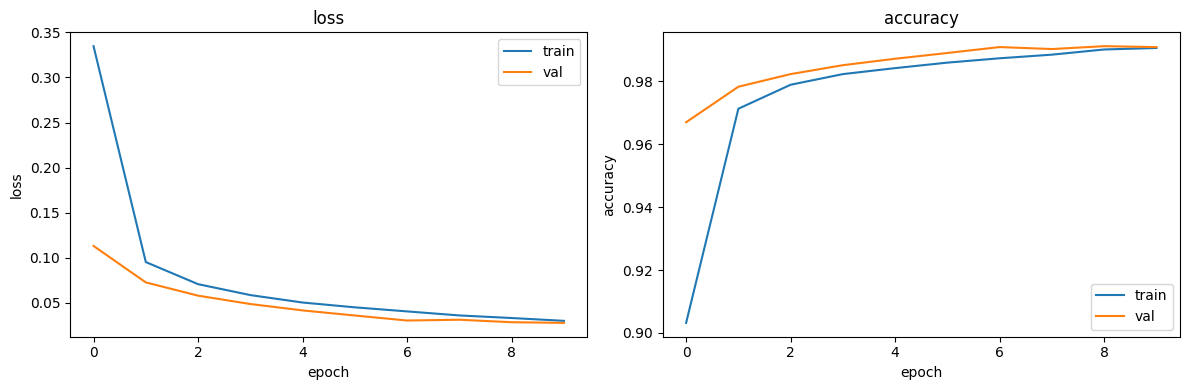

In [9]:
view_loss_acc([train_losses,val_losses,train_accs,val_accs])

In [ ]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        # Move data and targets to the device (GPU/CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass: compute the model output
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass: compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # Optimization step: update the model parameters
        optimizer.step()



In [ ]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass: compute the model output
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            num_correct += (predictions == y).sum()  # Count correct predictions
            num_samples += predictions.size(0)  # Count total samples

        # Calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    
    model.train()  # Set the model back to training mode

# Final accuracy check on training and test sets
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)


Checking accuracy on training data
Got 59203/60000 with accuracy 98.67%
Checking accuracy on test data
Got 9826/10000 with accuracy 98.26%


In [ ]:
# data processing
X = torch.tensor(data, dtype=torch.float32) / 255.0
y = torch.tensor(labels, dtype=torch.long)

N = X.shape[0]
train_size = int(0.8 * N)
val_size = N - train_size
train_X, val_X = torch.split(X, [train_size, val_size])
train_y, val_y = torch.split(y, [train_size, val_size])

train_ds = TensorDataset(train_X, train_y)
val_ds = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=0)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)


# MNIST
from torchvision import datasets, transforms
train_ds = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

# CIFAR10 
train_ds = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())


# data flat (N,3072) 
data = data.reshape(-1,3,32,32)

from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Test 1 batch
for xb, yb in train_loader:
    print(xb.shape, yb.shape)  # doit être [128, C, H, W], [128]
    break

# Test forward
model = CNN()
out = model(xb)
print(out.shape)  # [128, 10]


NameError: name 'data' is not defined